In this project, we will try to find an optimal location for a restaurant. Specifically, the objective is to choose a location for an Italian restaurant, given that we are currently based in **Mesquite, Texas**.

## Step 1: Cleaning the Data

In [337]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import json
import requests
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import seaborn as sns

In [277]:
df=pd.read_csv('largest_us_cities.csv',sep=';')
df.head()

,City,Rank,State,Growth From 2000 to 2013,Population,Coordinates
0,Marysville,552,Washington,115.7,63269,"48.0517637,-122.1770818"
1,Perris,466,California,98.7,72326,"33.7825194,-117.2286478"
2,Cleveland,48,Ohio,-18.1,390113,"41.49932,-81.6943605"
3,Worcester,129,Massachusetts,5.8,182544,"42.2625932,-71.8022934"
4,Columbia,192,South Carolina,11.7,133358,"34.0007104,-81.0348144"


In [278]:
df.dtypes

City                         object
Rank                          int64
State                        object
Growth From 2000 to 2013    float64
Population                    int64
Coordinates                  object
dtype: object

Let's begin to normalize and clean the data that we have here. First, get rid of unneeded rank column. 

In [279]:
df.drop('Rank',axis=1,inplace=True)

Next, let's normalize the percentage growth such that 100% corresponds to 1 and -100% corresponds to -1. Let's also rename the column.

In [280]:
df=df.rename({'Growth From 2000 to 2013':'Growth'},axis=1)

In [281]:
df['Growth']/=100
df.head()

,City,State,Growth,Population,Coordinates
0,Marysville,Washington,1.157,63269,"48.0517637,-122.1770818"
1,Perris,California,0.987,72326,"33.7825194,-117.2286478"
2,Cleveland,Ohio,-0.181,390113,"41.49932,-81.6943605"
3,Worcester,Massachusetts,0.058,182544,"42.2625932,-71.8022934"
4,Columbia,South Carolina,0.117,133358,"34.0007104,-81.0348144"


Next, let's split the coordinate column into Latitude and Longitude. 

In [282]:
df[['Latitude','Longitude']]=pd.DataFrame(df['Coordinates'].apply(lambda x:list(map(float,x.split(',')))).tolist(),index=df.index)
df.drop('Coordinates',axis=1,inplace=True)
df.head()

,City,State,Growth,Population,Latitude,Longitude
0,Marysville,Washington,1.157,63269,48.051764,-122.177082
1,Perris,California,0.987,72326,33.782519,-117.228648
2,Cleveland,Ohio,-0.181,390113,41.499320,-81.694361
3,Worcester,Massachusetts,0.058,182544,42.262593,-71.802293
4,Columbia,South Carolina,0.117,133358,34.000710,-81.034814


Let's also concatenate the city and state columns. 

In [283]:
df['Location']=df['City']+', '+df['State']
df.drop(columns=['City','State'],inplace=True)
df=df[['Location']+df.columns.to_list()[:-1]]
df.head()

,Location,Growth,Population,Latitude,Longitude
0,"Marysville, Washington",1.157,63269,48.051764,-122.177082
1,"Perris, California",0.987,72326,33.782519,-117.228648
2,"Cleveland, Ohio",-0.181,390113,41.499320,-81.694361
3,"Worcester, Massachusetts",0.058,182544,42.262593,-71.802293
4,"Columbia, South Carolina",0.117,133358,34.000710,-81.034814


Now, let's check for null values. 

In [284]:
df.isna().sum()

Location      0
Growth        6
Population    0
Latitude      0
Longitude     0
dtype: int64

Let's replace the null growth values with 0.

In [285]:
df.fillna(0,inplace=True)

In [286]:
df.to_pickle('./population.pkl')

## Step 2: Foursquare

In [287]:
df_pop=pd.read_pickle('./population.pkl')
df_pop.head()

,Location,Growth,Population,Latitude,Longitude
0,"Marysville, Washington",1.157,63269,48.051764,-122.177082
1,"Perris, California",0.987,72326,33.782519,-117.228648
2,"Cleveland, Ohio",-0.181,390113,41.499320,-81.694361
3,"Worcester, Massachusetts",0.058,182544,42.262593,-71.802293
4,"Columbia, South Carolina",0.117,133358,34.000710,-81.034814


In [288]:
with open('credentials.json','r') as f:
    secret_info=json.load(f)
CLIENT_ID=secret_info['CLIENT_ID']
CLIENT_SECRET=secret_info['CLIENT_SECRET']
VERSION=secret_info['VERSION']

In [289]:
# Category ids were taken from Foursquare API at https://developer.foursquare.com/docs/build-with-foursquare/categories/

food_category = '4d4b7105d754a06374d81259'

In [290]:
def get_primary_cat(venue):
    return [v['name'] for v in venue['venue']['categories'] if v['primary']][0]

def get_venues_from_location(name,lat,lng,radius,limit):
    
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&categoryId={food_category}&ll={lat},{lng}&radius={radius}&limit={limit}'

            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        return [(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            get_primary_cat(v)) for v in results]
    
def get_recommended_venues(names, latitudes, longitudes, radius=20000,limit=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        done=False
        while not done:
            print(name)

            # return only relevant information for each nearby venue
            try:
                venues_list.append(get_venues_from_location(name,lat,lng,radius,limit))
                done=True
            except:
                print('Failed. Trying again...')
            

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                'City Latitude', 
                'City Longitude', 
                'Name', 
                'Latitude', 
                'Longitude', 
                'Category']
    
    return(nearby_venues)

In [291]:
try:
    df_explore=pd.read_pickle('foursquare_explore.pkl')
except:
    df_explore=get_recommended_venues(df_pop['Location'],df_pop['Latitude'],df_pop['Longitude'])
    df_explore.to_pickle('foursquare_explore.pkl')

In [292]:
df_explore.head()

,Location,City Latitude,City Longitude,Name,Latitude,Longitude,Category
0,"Marysville, Washington",48.051764,-122.177082,MOD Pizza,48.051566,-122.177439,Pizza Place
1,"Marysville, Washington",48.051764,-122.177082,Cristiano's Pizza Etc,48.061627,-122.175588,Pizza Place
2,"Marysville, Washington",48.051764,-122.177082,Jeff's Texas Style BBQ,48.079681,-122.175354,BBQ Joint
3,"Marysville, Washington",48.051764,-122.177082,Don's Restaurant,48.051796,-122.181238,American Restaurant
4,"Marysville, Washington",48.051764,-122.177082,Tres Hermanos,48.101007,-122.174620,Mexican Restaurant


In [293]:
df_explore.shape

(95729, 7)

Let's graph the most common restaurants found. 

In [351]:
df_types=df_explore.groupby('Category',sort='true').count()[['Name']].sort_values(by='Name',ascending=False)
df_types.columns=['Type Count']
df_types.reset_index(inplace=True)
df_types.head()

,Category,Type Count
0,Mexican Restaurant,8515
1,Pizza Place,8265
2,American Restaurant,7501
3,Sandwich Place,5478
4,Fast Food Restaurant,5041


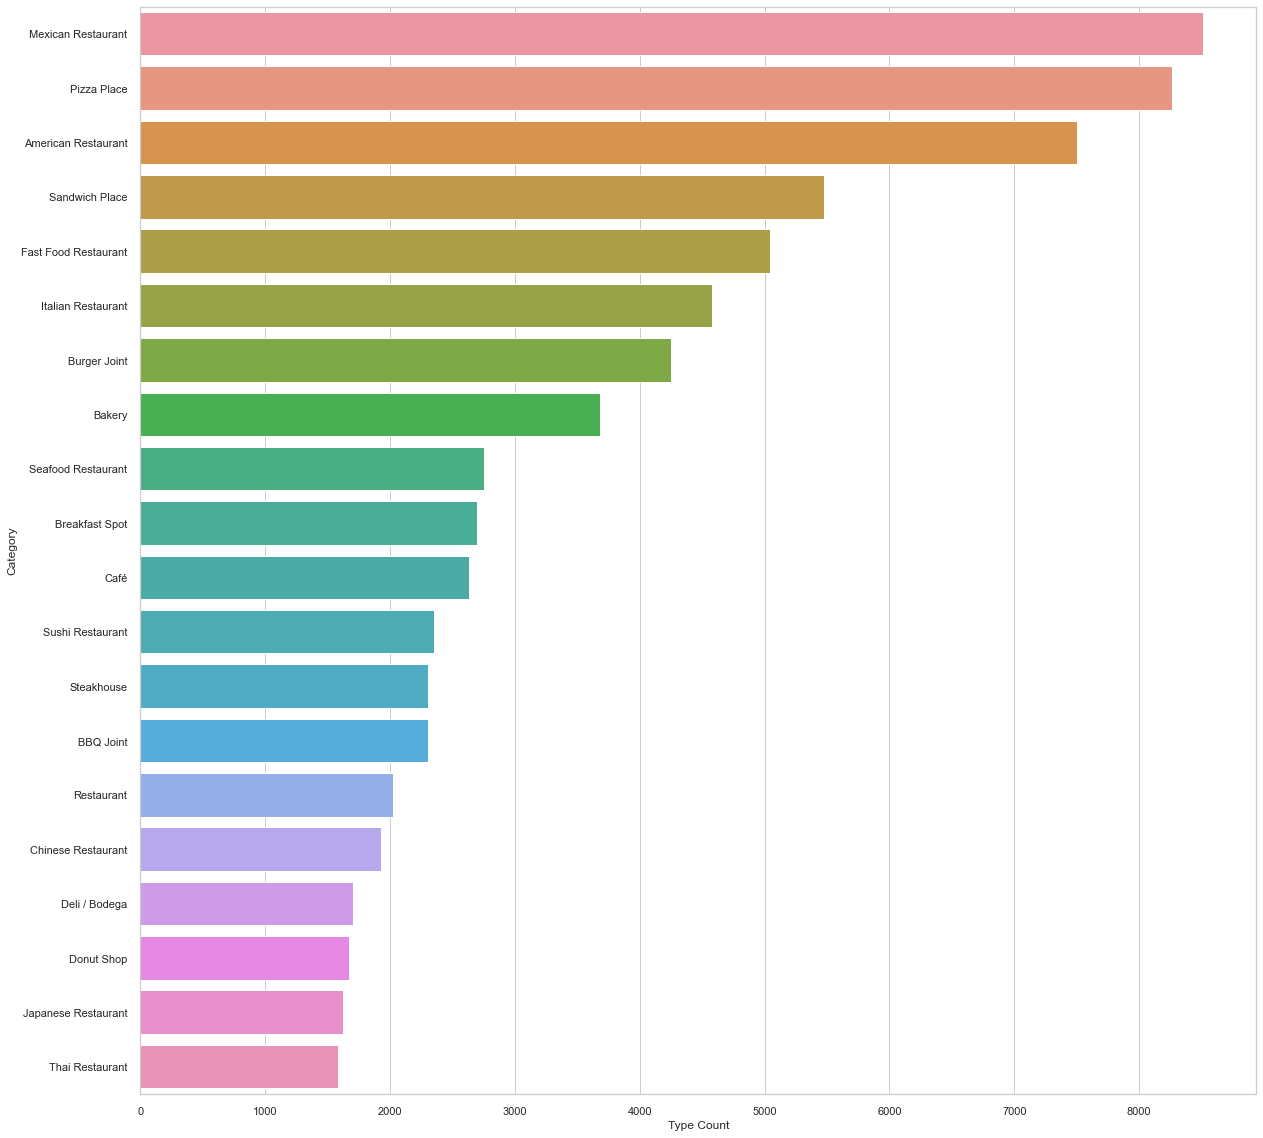

In [352]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set(style='whitegrid')
sns.barplot(x='Type Count',y='Category',data=df_types.head(20))

In [354]:
print(f'There are {len(df_explore["Category"].unique())} unique venue categories.')

There are 143 unique venue categories.


In [294]:
print(sorted(df_explore.groupby('Location').count()['Name'].unique(),reverse=True)[0:5])
print(df_explore.groupby('Location').count())

[100, 99, 98, 97, 96]
                       City Latitude  City Longitude  Name  Latitude  \
Location                                                               
Abilene, Texas                    92              92    92        92   
Addison, Illinois                100             100   100       100   
Akron, Ohio                      100             100   100       100   
Alameda, California              100             100   100       100   
Albany, Georgia                   71              71    71        71   
...                              ...             ...   ...       ...   
York, Pennsylvania               100             100   100       100   
Youngstown, Ohio                  98              98    98        98   
Yuba City, California            100             100   100       100   
Yucaipa, California              100             100   100       100   
Yuma, Arizona                    100             100   100       100   

                       Longitude  Categor

In [295]:
explore_onehot=pd.get_dummies(df_explore['Category'])
explore_onehot=df_explore[['Location']].join(explore_onehot) # Add the city name as well
explore_onehot.head()

,Location,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Truck Stop,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Marysville, Washington",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Marysville, Washington",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Marysville, Washington",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,"Marysville, Washington",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Marysville, Washington",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [296]:
explore_grouped=explore_onehot.groupby('Location').mean()
explore_grouped.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Truck Stop,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
Location,,,,,,,,,,,,,,,,,,,,,
"Abilene, Texas",0.0,0.0,0.097826,0.0,0.00,0.00,0.0,0.0,0.032609,0.01087,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.032609
"Addison, Illinois",0.0,0.0,0.070000,0.0,0.00,0.01,0.0,0.0,0.030000,0.00000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.020000
"Akron, Ohio",0.0,0.0,0.110000,0.0,0.00,0.01,0.0,0.0,0.000000,0.00000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.020000
"Alameda, California",0.0,0.0,0.020000,0.0,0.01,0.00,0.0,0.0,0.000000,0.02000,...,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.04,0.000000
"Albany, Georgia",0.0,0.0,0.084507,0.0,0.00,0.00,0.0,0.0,0.070423,0.00000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.028169


Let's get a dataframe to represent the most common venues by city. 

In [297]:
columns=['Location']
endings=['st','nd','rd','th']
for ind in range(20):
    columns.append(f'{ind+1}{endings[min(ind,3)]} Most Common Venue')
# columns
explore_grouped_sorted=pd.DataFrame(columns=columns)
for idx,row in enumerate(explore_grouped.iterrows()):
    explore_grouped_sorted.loc[idx,'Location']=row[0]
    explore_grouped_sorted.iloc[idx,1:]=row[1].sort_values(ascending=False).index.values[0:20]
explore_grouped_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Abilene, Texas",Mexican Restaurant,American Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Deli / Bodega,Restaurant,Burger Joint,Steakhouse,...,Café,Fried Chicken Joint,Wings Joint,BBQ Joint,Tex-Mex Restaurant,Italian Restaurant,Food Court,Food,Thai Restaurant,Donut Shop
1,"Addison, Illinois",Pizza Place,Hot Dog Joint,Mexican Restaurant,Seafood Restaurant,American Restaurant,Steakhouse,Italian Restaurant,Fast Food Restaurant,Sandwich Place,...,Burger Joint,Japanese Restaurant,Snack Place,BBQ Joint,New American Restaurant,Deli / Bodega,Restaurant,Chinese Restaurant,Café,Wings Joint
2,"Akron, Ohio",Mexican Restaurant,American Restaurant,Burger Joint,Italian Restaurant,Diner,Breakfast Spot,Sandwich Place,Bakery,Pizza Place,...,Chinese Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Deli / Bodega,Fast Food Restaurant,Mediterranean Restaurant,Café,Wings Joint,Gastropub,Steakhouse
3,"Alameda, California",Pizza Place,Bakery,Café,Mexican Restaurant,Breakfast Spot,New American Restaurant,Vietnamese Restaurant,Italian Restaurant,Sandwich Place,...,Food Truck,Mediterranean Restaurant,Burmese Restaurant,Deli / Bodega,Salad Place,Fast Food Restaurant,Spanish Restaurant,Southern / Soul Food Restaurant,French Restaurant,Taco Place
4,"Albany, Georgia",Fast Food Restaurant,Sandwich Place,Mexican Restaurant,American Restaurant,BBQ Joint,Chinese Restaurant,Fried Chicken Joint,Pizza Place,Seafood Restaurant,...,Food,Southern / Soul Food Restaurant,Breakfast Spot,Donut Shop,Japanese Restaurant,Food Stand,Café,Hot Dog Joint,Steakhouse,Deli / Bodega


Now, let's determine the optimal k for clustering. 

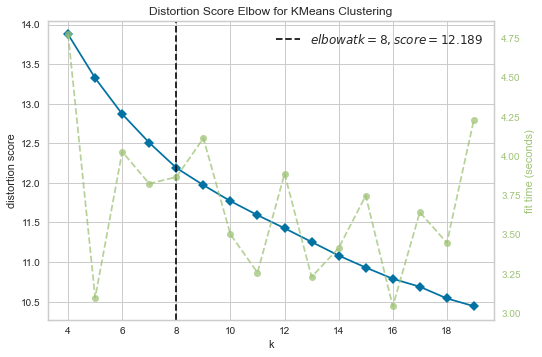

In [298]:
kmeans=KMeans()
visualizer=KElbowVisualizer(kmeans,k=(4,20))
visualizer.fit(explore_grouped)
visualizer.show()

The point with maximum curvature is at k=9. As such, we will cluster our cities with 9 clusters. 

In [299]:
k=9
kmeans.n_clusters=k
kmeans.fit(explore_grouped)

KMeans(n_clusters=9)

In [300]:
explore_merged=explore_grouped_sorted.copy(deep=True)
explore_merged.insert(0,'Cluster',kmeans.labels_)
explore_merged=df_pop.merge(explore_merged,on='Location')
explore_merged.head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Marysville, Washington",1.157,63269,48.051764,-122.177082,0,Burger Joint,Mexican Restaurant,Pizza Place,American Restaurant,...,Chinese Restaurant,Sushi Restaurant,Breakfast Spot,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Greek Restaurant,Vietnamese Restaurant,Restaurant,Café
1,"Perris, California",0.987,72326,33.782519,-117.228648,2,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Burger Joint,...,Seafood Restaurant,Bakery,Wings Joint,BBQ Joint,Thai Restaurant,Café,Hot Dog Joint,Asian Restaurant,Restaurant,Comfort Food Restaurant
2,"Cleveland, Ohio",-0.181,390113,41.499320,-81.694361,0,Sandwich Place,American Restaurant,Bakery,Mexican Restaurant,...,Café,Steakhouse,Middle Eastern Restaurant,Lebanese Restaurant,Japanese Restaurant,New American Restaurant,Mediterranean Restaurant,Wings Joint,Sushi Restaurant,Diner
3,"Worcester, Massachusetts",0.058,182544,42.262593,-71.802293,6,American Restaurant,Pizza Place,Breakfast Spot,Bakery,...,Sandwich Place,Sushi Restaurant,Fast Food Restaurant,Restaurant,Café,Diner,Burger Joint,Deli / Bodega,Hot Dog Joint,Steakhouse
4,"Columbia, South Carolina",0.117,133358,34.000710,-81.034814,3,Burger Joint,Pizza Place,Mexican Restaurant,American Restaurant,...,Café,Southern / Soul Food Restaurant,Steakhouse,Fried Chicken Joint,Sushi Restaurant,Breakfast Spot,Restaurant,New American Restaurant,Italian Restaurant,BBQ Joint


Let's visualize our clusters. 

In [316]:
us_lat=37.0902
us_long=-95.7129
def map_clusters(dataframe,cluster_count):
    map_cluster=folium.Map(location=[us_lat,us_long],zoom_start=4)

    colors_arr=list(map(colors.rgb2hex,cm.Spectral(np.linspace(0,1,cluster_count))))
    for row in dataframe.iterrows():
        r=row[1]
        label=folium.Popup(f'{r["Location"]} - Cluster {r["Cluster"]+1}')
        folium.CircleMarker(
            [r['Latitude'],r['Longitude']],
            radius=5,
            popup=label,
            color=colors_arr[r["Cluster"]],
            fill=True,
            fill_color=colors_arr[r["Cluster"]],
            fill_opacity=0.7
        ).add_to(map_cluster)
    return map_cluster
map_clusters(explore_merged,k)

**Cluster 1**

In [304]:
explore_merged[explore_merged['Cluster']==0].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Marysville, Washington",1.157,63269,48.051764,-122.177082,0,Burger Joint,Mexican Restaurant,Pizza Place,American Restaurant,...,Chinese Restaurant,Sushi Restaurant,Breakfast Spot,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Greek Restaurant,Vietnamese Restaurant,Restaurant,Café
2,"Cleveland, Ohio",-0.181,390113,41.499320,-81.694361,0,Sandwich Place,American Restaurant,Bakery,Mexican Restaurant,...,Café,Steakhouse,Middle Eastern Restaurant,Lebanese Restaurant,Japanese Restaurant,New American Restaurant,Mediterranean Restaurant,Wings Joint,Sushi Restaurant,Diner
9,"Boise City, Idaho",0.095,214237,43.618710,-116.214607,0,Pizza Place,Mexican Restaurant,Burger Joint,Italian Restaurant,...,Fast Food Restaurant,Thai Restaurant,Steakhouse,Sushi Restaurant,Seafood Restaurant,Bagel Shop,BBQ Joint,Indian Restaurant,Chinese Restaurant,Donut Shop
10,"Elkhart, Indiana",-0.025,51265,41.681993,-85.976667,0,Pizza Place,American Restaurant,Sandwich Place,Italian Restaurant,...,Steakhouse,Burger Joint,Café,Restaurant,Greek Restaurant,Seafood Restaurant,Mediterranean Restaurant,Deli / Bodega,Noodle House,Donut Shop
13,"Parker, Colorado",0.964,48608,39.518600,-104.761363,0,Pizza Place,Sandwich Place,Mexican Restaurant,American Restaurant,...,Wings Joint,Taco Place,Steakhouse,Fried Chicken Joint,Breakfast Spot,Japanese Restaurant,Bakery,Donut Shop,Mediterranean Restaurant,Diner


**Cluster 2**

In [305]:
explore_merged[explore_merged['Cluster']==1].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
5,"Waterbury, Connecticut",0.022,109676,41.558152,-73.051496,1,Pizza Place,Italian Restaurant,American Restaurant,Bagel Shop,...,Breakfast Spot,Steakhouse,Hot Dog Joint,Diner,Sushi Restaurant,Donut Shop,Mexican Restaurant,Seafood Restaurant,Wings Joint,Restaurant
6,"Eagan, Minnesota",0.026,65453,44.804132,-93.166886,1,Pizza Place,Italian Restaurant,Bakery,Burger Joint,...,Vietnamese Restaurant,Fried Chicken Joint,Mediterranean Restaurant,Fast Food Restaurant,BBQ Joint,Breakfast Spot,French Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant
7,"Southfield, Michigan",-0.067,73006,42.473369,-83.221873,1,Pizza Place,American Restaurant,Italian Restaurant,Middle Eastern Restaurant,...,Mediterranean Restaurant,Donut Shop,Diner,Deli / Bodega,Seafood Restaurant,Greek Restaurant,Bagel Shop,Mexican Restaurant,Southern / Soul Food Restaurant,Thai Restaurant
15,"Salem, Massachusetts",0.051,42544,42.519540,-70.896715,1,Pizza Place,Italian Restaurant,Diner,Sandwich Place,...,Deli / Bodega,Chinese Restaurant,Café,Thai Restaurant,Burger Joint,Breakfast Spot,New American Restaurant,Restaurant,Salad Place,Fast Food Restaurant
33,"Allentown, Pennsylvania",0.112,118577,40.608430,-75.490183,1,American Restaurant,Italian Restaurant,Pizza Place,Hot Dog Joint,...,Café,Restaurant,Chinese Restaurant,Steakhouse,Asian Restaurant,Deli / Bodega,Breakfast Spot,Middle Eastern Restaurant,Seafood Restaurant,Burger Joint


**Cluster 3**

In [306]:
explore_merged[explore_merged['Cluster']==2].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1,"Perris, California",0.987,72326,33.782519,-117.228648,2,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Burger Joint,...,Seafood Restaurant,Bakery,Wings Joint,BBQ Joint,Thai Restaurant,Café,Hot Dog Joint,Asian Restaurant,Restaurant,Comfort Food Restaurant
20,"Lubbock, Texas",0.196,239538,33.577863,-101.855166,2,Mexican Restaurant,Burger Joint,Steakhouse,American Restaurant,...,Italian Restaurant,Taco Place,Café,Breakfast Spot,Bakery,Burrito Place,Restaurant,Deli / Bodega,Asian Restaurant,Donut Shop
47,"Covina, California",0.033,48508,34.090009,-117.890340,2,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Burger Joint,...,Mediterranean Restaurant,Donut Shop,Gastropub,Sushi Restaurant,Seafood Restaurant,Steakhouse,Taco Place,Vietnamese Restaurant,New American Restaurant,Hot Dog Joint
55,"Visalia, California",0.336,127763,36.330228,-119.292058,2,Mexican Restaurant,Burger Joint,Fast Food Restaurant,American Restaurant,...,Mediterranean Restaurant,Seafood Restaurant,Vietnamese Restaurant,Breakfast Spot,Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Thai Restaurant,Indian Restaurant,Italian Restaurant
60,"Antioch, California",0.169,107100,38.004921,-121.805789,2,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Pizza Place,...,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,Indian Restaurant,Fried Chicken Joint,Bakery,Taco Place,Italian Restaurant,Restaurant,Steakhouse


**Cluster 4**

In [307]:
explore_merged[explore_merged['Cluster']==3].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
4,"Columbia, South Carolina",0.117,133358,34.000710,-81.034814,3,Burger Joint,Pizza Place,Mexican Restaurant,American Restaurant,...,Café,Southern / Soul Food Restaurant,Steakhouse,Fried Chicken Joint,Sushi Restaurant,Breakfast Spot,Restaurant,New American Restaurant,Italian Restaurant,BBQ Joint
8,"Lafayette, Louisiana",0.110,124276,30.224090,-92.019843,3,Cajun / Creole Restaurant,Pizza Place,Fast Food Restaurant,Burger Joint,...,Bakery,Sushi Restaurant,American Restaurant,Steakhouse,Café,Donut Shop,Deli / Bodega,Restaurant,Mediterranean Restaurant,Chinese Restaurant
11,"Buena Park, California",0.061,82882,33.867514,-117.998118,3,Pizza Place,Mexican Restaurant,Bakery,Burger Joint,...,Steakhouse,Sandwich Place,Korean Restaurant,Japanese Restaurant,Food Court,Italian Restaurant,Deli / Bodega,Greek Restaurant,Thai Restaurant,Indian Restaurant
12,"Marietta, Georgia",-0.038,59089,33.952602,-84.549933,3,Mexican Restaurant,Pizza Place,Burger Joint,Seafood Restaurant,...,Taco Place,Thai Restaurant,Donut Shop,Sandwich Place,American Restaurant,Caribbean Restaurant,Breakfast Spot,Cuban Restaurant,Korean Restaurant,Southern / Soul Food Restaurant
19,"Westminster, California",0.039,91739,33.751342,-117.993992,3,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Burger Joint,...,Sandwich Place,Steakhouse,Donut Shop,Pizza Place,Food Court,Taco Place,Tapas Restaurant,Poke Place,Breakfast Spot,Vegetarian / Vegan Restaurant


**Cluster 5**

In [308]:
explore_merged[explore_merged['Cluster']==4].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
29,"Roswell, New Mexico",0.075,48611,33.394266,-104.523024,4,Pizza Place,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,...,Thai Restaurant,Hot Dog Joint,American Restaurant,Café,Diner,Burrito Place,Burger Joint,Food Truck,Buffet,Steakhouse
46,"Henderson, Nevada",0.510,270811,36.039525,-114.981721,4,American Restaurant,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,...,Italian Restaurant,BBQ Joint,Taco Place,Greek Restaurant,Deli / Bodega,Seafood Restaurant,Wings Joint,Creperie,French Restaurant,Indian Restaurant
50,"Kingsport, Tennessee",0.167,52962,36.548434,-82.561819,4,Fast Food Restaurant,Sandwich Place,American Restaurant,Mexican Restaurant,...,Breakfast Spot,Hot Dog Joint,Asian Restaurant,Steakhouse,Bakery,Chinese Restaurant,Donut Shop,Japanese Restaurant,Tex-Mex Restaurant,Deli / Bodega
79,"Tulare, California",0.333,61170,36.207729,-119.347338,4,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,...,Diner,Seafood Restaurant,Chinese Restaurant,Bakery,Breakfast Spot,Japanese Restaurant,Mediterranean Restaurant,Gastropub,Donut Shop,Vegetarian / Vegan Restaurant
82,"Concord, North Carolina",0.474,83506,35.408752,-80.579511,4,Fast Food Restaurant,Pizza Place,American Restaurant,Mexican Restaurant,...,Restaurant,Bakery,Italian Restaurant,Steakhouse,Deli / Bodega,Indian Restaurant,Greek Restaurant,Diner,Breakfast Spot,Peruvian Restaurant


**Cluster 6**

In [309]:
explore_merged[explore_merged['Cluster']==5].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
18,"Doral, Florida",1.376,50213,25.819542,-80.355330,5,Cuban Restaurant,American Restaurant,Latin American Restaurant,Pizza Place,...,South American Restaurant,Fast Food Restaurant,Argentinian Restaurant,Sushi Restaurant,Arepa Restaurant,Spanish Restaurant,Mexican Restaurant,Steakhouse,Restaurant,Greek Restaurant
22,"Jackson, Mississippi",-0.068,172638,32.298757,-90.184810,5,American Restaurant,Seafood Restaurant,Japanese Restaurant,Burger Joint,...,Mediterranean Restaurant,Donut Shop,Steakhouse,Sushi Restaurant,Pizza Place,Italian Restaurant,Wings Joint,Restaurant,Chinese Restaurant,BBQ Joint
23,"Gastonia, North Carolina",0.082,73209,35.262082,-81.187301,5,American Restaurant,Seafood Restaurant,Pizza Place,BBQ Joint,...,Japanese Restaurant,Fried Chicken Joint,Burger Joint,Southern / Soul Food Restaurant,Gastropub,Restaurant,Chinese Restaurant,Diner,Bakery,Sushi Restaurant
24,"Daytona Beach, Florida",-0.023,62316,29.210815,-81.022833,5,American Restaurant,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,...,Thai Restaurant,Bakery,Fast Food Restaurant,Sandwich Place,BBQ Joint,Tex-Mex Restaurant,Asian Restaurant,Sushi Restaurant,South American Restaurant,Mediterranean Restaurant
34,"Mount Pleasant, South Carolina",0.532,74885,32.832322,-79.828426,5,American Restaurant,Seafood Restaurant,Pizza Place,Café,...,Fast Food Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,Burger Joint,Vietnamese Restaurant,Gastropub,Mexican Restaurant,Breakfast Spot,Vegetarian / Vegan Restaurant,Hot Dog Joint


**Cluster 7**

In [310]:
explore_merged[explore_merged['Cluster']==6].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
3,"Worcester, Massachusetts",0.058,182544,42.262593,-71.802293,6,American Restaurant,Pizza Place,Breakfast Spot,Bakery,...,Sandwich Place,Sushi Restaurant,Fast Food Restaurant,Restaurant,Café,Diner,Burger Joint,Deli / Bodega,Hot Dog Joint,Steakhouse
14,"West Palm Beach, Florida",0.235,102436,26.715342,-80.053375,6,American Restaurant,Sandwich Place,Steakhouse,Pizza Place,...,French Restaurant,Thai Restaurant,Café,Asian Restaurant,Restaurant,Fast Food Restaurant,Latin American Restaurant,Donut Shop,Indian Restaurant,Greek Restaurant
16,"Aurora, Illinois",0.384,199963,41.760585,-88.320071,6,Mexican Restaurant,American Restaurant,Pizza Place,Breakfast Spot,...,Steakhouse,Fast Food Restaurant,Japanese Restaurant,Sushi Restaurant,Restaurant,Fried Chicken Joint,Café,Greek Restaurant,Wings Joint,Tapas Restaurant
17,"Leesburg, Virginia",0.660,47673,39.115662,-77.563602,6,American Restaurant,Pizza Place,Sandwich Place,Burger Joint,...,Bakery,Thai Restaurant,Mediterranean Restaurant,Indian Restaurant,Sushi Restaurant,Diner,Italian Restaurant,Wings Joint,Chinese Restaurant,Latin American Restaurant
21,"Overland Park, Kansas",0.194,181260,38.982228,-94.670792,6,American Restaurant,BBQ Joint,Pizza Place,Mexican Restaurant,...,Greek Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Donut Shop,Restaurant,Seafood Restaurant,Food Court,Middle Eastern Restaurant,Diner


**Cluster 8**

In [311]:
explore_merged[explore_merged['Cluster']==7].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
32,"Woburn, Massachusetts",0.044,39083,42.479262,-71.152276,7,Bakery,Café,Pizza Place,Mexican Restaurant,...,Breakfast Spot,New American Restaurant,Sushi Restaurant,Salad Place,Burrito Place,Japanese Restaurant,Vegetarian / Vegan Restaurant,Peruvian Restaurant,Comfort Food Restaurant,Cuban Restaurant
53,"Philadelphia, Pennsylvania",0.026,1553165,39.952584,-75.165222,7,Café,Pizza Place,Sandwich Place,Gastropub,...,Israeli Restaurant,Breakfast Spot,Vietnamese Restaurant,Restaurant,Sushi Restaurant,Japanese Restaurant,Salad Place,Taco Place,Tapas Restaurant,Thai Restaurant
94,"Portland, Oregon",0.150,609456,45.523062,-122.676482,7,Thai Restaurant,Italian Restaurant,Sandwich Place,Bakery,...,Deli / Bodega,Israeli Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Food Truck,Korean Restaurant,New American Restaurant,Restaurant,Seafood Restaurant,Burger Joint
96,"Burien, Washington",0.567,49858,47.470377,-122.346792,7,Vietnamese Restaurant,Pizza Place,Bakery,Burger Joint,...,Donut Shop,BBQ Joint,Fried Chicken Joint,Seafood Restaurant,French Restaurant,Japanese Restaurant,Dumpling Restaurant,Indian Restaurant,Diner,American Restaurant
130,"Boston, Massachusetts",0.094,645966,42.360082,-71.058880,7,Bakery,Pizza Place,Italian Restaurant,Seafood Restaurant,...,Sandwich Place,Salad Place,Food Court,Japanese Restaurant,Latin American Restaurant,Chinese Restaurant,Greek Restaurant,Burrito Place,Taco Place,Donut Shop


**Cluster 9**

In [312]:
explore_merged[explore_merged['Cluster']==8].head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
31,"Logan, Utah",0.145,48913,41.736980,-111.833836,8,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,...,Burger Joint,Breakfast Spot,Sushi Restaurant,Mongolian Restaurant,Café,Steakhouse,Wings Joint,BBQ Joint,Taco Place,Tex-Mex Restaurant
56,"La Crosse, Wisconsin",-0.008,51522,43.801356,-91.239581,8,Sandwich Place,American Restaurant,Mexican Restaurant,Pizza Place,...,BBQ Joint,Hot Dog Joint,Chinese Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Fried Chicken Joint,Burrito Place,Burger Joint,Food,French Restaurant
74,"DeKalb, Illinois",0.118,43849,41.929474,-88.750365,8,Pizza Place,Sandwich Place,American Restaurant,Mexican Restaurant,...,Hot Dog Joint,Mediterranean Restaurant,Café,Fried Chicken Joint,Sushi Restaurant,Donut Shop,Bakery,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant
86,"Lancaster, Ohio",0.107,39325,39.713675,-82.599329,8,Pizza Place,Sandwich Place,American Restaurant,Fast Food Restaurant,...,Wings Joint,Japanese Restaurant,Snack Place,Gastropub,Greek Restaurant,Italian Restaurant,Donut Shop,Steakhouse,Seafood Restaurant,Burger Joint
103,"Springfield, Illinois",0.042,117006,39.781721,-89.650148,8,Sandwich Place,American Restaurant,Pizza Place,Mexican Restaurant,...,Thai Restaurant,New American Restaurant,Wings Joint,Diner,Café,BBQ Joint,Asian Restaurant,Deli / Bodega,Fried Chicken Joint,Greek Restaurant


Let's figure out which cluster our home city of Mesquite, Texas belongs to. 

In [313]:
explore_merged[explore_merged['Location']=='Mesquite, Texas']

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
910,"Mesquite, Texas",0.147,143484,32.766796,-96.599159,3,Burger Joint,Mexican Restaurant,Taco Place,American Restaurant,...,Thai Restaurant,Bakery,Sushi Restaurant,Donut Shop,Latin American Restaurant,Fried Chicken Joint,Steakhouse,Wings Joint,Gastropub,Vegetarian / Vegan Restaurant


We can see that it belongs to cluster 4. Let's look at that cluster a bit more.

In [320]:
explore_c3=explore_merged[explore_merged['Cluster']==3]
explore_c3.sort_values('Population',ascending=False)

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
607,"Houston, Texas",0.110,2195914,29.760427,-95.369803,3,Mexican Restaurant,American Restaurant,Taco Place,New American Restaurant,...,Sandwich Place,Café,Cajun / Creole Restaurant,Japanese Restaurant,Steakhouse,Sushi Restaurant,Modern European Restaurant,BBQ Joint,Fried Chicken Joint,Mediterranean Restaurant
59,"Dallas, Texas",0.056,1257676,32.776664,-96.796988,3,Mexican Restaurant,Pizza Place,American Restaurant,Burger Joint,...,Sandwich Place,Restaurant,Diner,Seafood Restaurant,Latin American Restaurant,Gastropub,Vegetarian / Vegan Restaurant,Sushi Restaurant,Bakery,BBQ Joint
779,"Fort Worth, Texas",0.451,792727,32.755488,-97.330766,3,Mexican Restaurant,Burger Joint,Pizza Place,Sushi Restaurant,...,Thai Restaurant,Diner,Fast Food Restaurant,Breakfast Spot,American Restaurant,Bakery,Deli / Bodega,Vietnamese Restaurant,French Restaurant,Italian Restaurant
934,"El Paso, Texas",0.194,674433,31.777576,-106.442456,3,Burger Joint,Mexican Restaurant,Steakhouse,Italian Restaurant,...,Wings Joint,Bakery,Fast Food Restaurant,Seafood Restaurant,Sushi Restaurant,Deli / Bodega,Spanish Restaurant,Diner,Breakfast Spot,Japanese Restaurant
232,"Oklahoma City, Oklahoma",0.202,610613,35.467560,-97.516428,3,Burger Joint,Mexican Restaurant,American Restaurant,Pizza Place,...,New American Restaurant,Vietnamese Restaurant,Bakery,Sushi Restaurant,Italian Restaurant,Comfort Food Restaurant,Taco Place,French Restaurant,Fried Chicken Joint,Asian Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,"Spartanburg, South Carolina",-0.062,37647,34.949567,-81.932048,3,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Sandwich Place,...,Steakhouse,Fried Chicken Joint,Japanese Restaurant,Bakery,Hot Dog Joint,Chinese Restaurant,Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,Café
719,"Phenix City, Alabama",0.319,37498,32.470976,-85.000765,3,Mexican Restaurant,Pizza Place,Fast Food Restaurant,BBQ Joint,...,Wings Joint,Fried Chicken Joint,Breakfast Spot,Korean Restaurant,Steakhouse,Sushi Restaurant,Café,Mediterranean Restaurant,Chinese Restaurant,Restaurant
107,"Lincoln Park, Michigan",-0.067,37313,42.250594,-83.178536,3,Mexican Restaurant,Middle Eastern Restaurant,Bakery,American Restaurant,...,Thai Restaurant,Café,Sandwich Place,Mediterranean Restaurant,Steakhouse,Restaurant,Food Truck,Diner,Chinese Restaurant,Bagel Shop
792,"Martinez, California",0.034,37165,38.019366,-122.134132,3,Mexican Restaurant,Burger Joint,Pizza Place,Italian Restaurant,...,Café,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Deli / Bodega,Sandwich Place,Steakhouse,Donut Shop,Peruvian Restaurant,Hot Dog Joint


In [360]:
map_clusters(explore_c3,k)

In [324]:
c3_cluster=explore_c3[['Location']].merge(explore_grouped,on='Location')
c3_cluster.set_index('Location',inplace=True)
c3_cluster.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Truck Stop,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
Location,,,,,,,,,,,,,,,,,,,,,
"Columbia, South Carolina",0.0,0.0,0.08,0.0,0.0,0.01,0.0,0.0,0.01,0.00,...,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0
"Lafayette, Louisiana",0.0,0.0,0.03,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.01,0.00,0.0,0.00,0.0,0.00,0.0
"Buena Park, California",0.0,0.0,0.06,0.0,0.0,0.00,0.0,0.0,0.03,0.00,...,0.0,0.0,0.0,0.00,0.00,0.0,0.01,0.0,0.00,0.0
"Marietta, Georgia",0.0,0.0,0.03,0.0,0.0,0.00,0.0,0.0,0.05,0.01,...,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.02,0.0
"Westminster, California",0.0,0.0,0.10,0.0,0.0,0.01,0.0,0.0,0.01,0.01,...,0.0,0.0,0.0,0.00,0.01,0.0,0.02,0.0,0.01,0.0


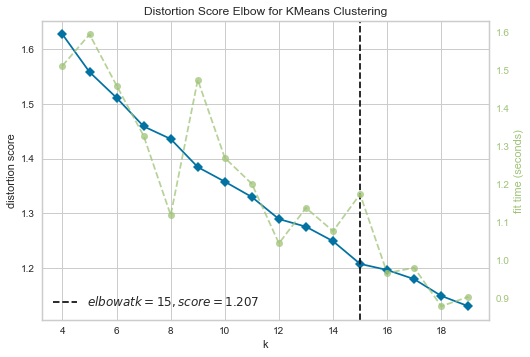

In [326]:
c3kmeans=KMeans()
c3visualizer=KElbowVisualizer(c3kmeans,k=(4,20))
c3visualizer.fit(c3_cluster)
c3visualizer.show()

In [327]:
c3k=15

c3kmeans.n_clusters=c3k
c3kmeans.fit(c3_cluster)
c3_merged=explore_c3.copy(deep=True)
c3_merged['Cluster']=c3kmeans.labels_
c3_merged.head()

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
4,"Columbia, South Carolina",0.117,133358,34.000710,-81.034814,3,Burger Joint,Pizza Place,Mexican Restaurant,American Restaurant,...,Café,Southern / Soul Food Restaurant,Steakhouse,Fried Chicken Joint,Sushi Restaurant,Breakfast Spot,Restaurant,New American Restaurant,Italian Restaurant,BBQ Joint
8,"Lafayette, Louisiana",0.110,124276,30.224090,-92.019843,11,Cajun / Creole Restaurant,Pizza Place,Fast Food Restaurant,Burger Joint,...,Bakery,Sushi Restaurant,American Restaurant,Steakhouse,Café,Donut Shop,Deli / Bodega,Restaurant,Mediterranean Restaurant,Chinese Restaurant
11,"Buena Park, California",0.061,82882,33.867514,-117.998118,4,Pizza Place,Mexican Restaurant,Bakery,Burger Joint,...,Steakhouse,Sandwich Place,Korean Restaurant,Japanese Restaurant,Food Court,Italian Restaurant,Deli / Bodega,Greek Restaurant,Thai Restaurant,Indian Restaurant
12,"Marietta, Georgia",-0.038,59089,33.952602,-84.549933,3,Mexican Restaurant,Pizza Place,Burger Joint,Seafood Restaurant,...,Taco Place,Thai Restaurant,Donut Shop,Sandwich Place,American Restaurant,Caribbean Restaurant,Breakfast Spot,Cuban Restaurant,Korean Restaurant,Southern / Soul Food Restaurant
19,"Westminster, California",0.039,91739,33.751342,-117.993992,1,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Burger Joint,...,Sandwich Place,Steakhouse,Donut Shop,Pizza Place,Food Court,Taco Place,Tapas Restaurant,Poke Place,Breakfast Spot,Vegetarian / Vegan Restaurant


In [355]:
map_clusters(c3_merged,c3k)

In [329]:
c3_merged[c3_merged['Location']=='Mesquite, Texas']

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
910,"Mesquite, Texas",0.147,143484,32.766796,-96.599159,14,Burger Joint,Mexican Restaurant,Taco Place,American Restaurant,...,Thai Restaurant,Bakery,Sushi Restaurant,Donut Shop,Latin American Restaurant,Fried Chicken Joint,Steakhouse,Wings Joint,Gastropub,Vegetarian / Vegan Restaurant


We see that our second clustering yields cluster 14. Let's examine it a bit more.

In [332]:
c3_merged[c3_merged['Cluster']==14]

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
59,"Dallas, Texas",0.056,1257676,32.776664,-96.796988,14,Mexican Restaurant,Pizza Place,American Restaurant,Burger Joint,...,Sandwich Place,Restaurant,Diner,Seafood Restaurant,Latin American Restaurant,Gastropub,Vegetarian / Vegan Restaurant,Sushi Restaurant,Bakery,BBQ Joint
232,"Oklahoma City, Oklahoma",0.202,610613,35.467560,-97.516428,14,Burger Joint,Mexican Restaurant,American Restaurant,Pizza Place,...,New American Restaurant,Vietnamese Restaurant,Bakery,Sushi Restaurant,Italian Restaurant,Comfort Food Restaurant,Taco Place,French Restaurant,Fried Chicken Joint,Asian Restaurant
504,"Richardson, Texas",0.132,104475,32.948333,-96.729852,14,Burger Joint,American Restaurant,Mexican Restaurant,Steakhouse,...,Italian Restaurant,Latin American Restaurant,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Bakery,Sushi Restaurant,Chinese Restaurant,Café,Mediterranean Restaurant
558,"Irving, Texas",0.191,228653,32.814018,-96.948894,14,Mexican Restaurant,American Restaurant,Burger Joint,Seafood Restaurant,...,Japanese Restaurant,Diner,Salad Place,Taco Place,Sushi Restaurant,Latin American Restaurant,French Restaurant,Bakery,Tex-Mex Restaurant,Thai Restaurant
588,"Midwest City, Oklahoma",0.045,56756,35.449506,-97.396702,14,American Restaurant,Burger Joint,Mexican Restaurant,Pizza Place,...,Sushi Restaurant,Vietnamese Restaurant,Taco Place,Steakhouse,New American Restaurant,Comfort Food Restaurant,Asian Restaurant,Latin American Restaurant,Café,Chinese Restaurant
607,"Houston, Texas",0.110,2195914,29.760427,-95.369803,14,Mexican Restaurant,American Restaurant,Taco Place,New American Restaurant,...,Sandwich Place,Café,Cajun / Creole Restaurant,Japanese Restaurant,Steakhouse,Sushi Restaurant,Modern European Restaurant,BBQ Joint,Fried Chicken Joint,Mediterranean Restaurant
643,"Edmond, Oklahoma",0.269,87004,35.652832,-97.478095,14,Burger Joint,Mexican Restaurant,American Restaurant,Pizza Place,...,Steakhouse,Bakery,Bagel Shop,BBQ Joint,Mediterranean Restaurant,Restaurant,Sandwich Place,Taco Place,French Restaurant,Vietnamese Restaurant
655,"Richmond, Virginia",0.082,214114,37.540725,-77.436048,14,American Restaurant,Burger Joint,Donut Shop,Mexican Restaurant,...,Italian Restaurant,Seafood Restaurant,Latin American Restaurant,Deli / Bodega,Diner,Greek Restaurant,French Restaurant,Thai Restaurant,Indian Restaurant,Southern / Soul Food Restaurant
658,"Pflugerville, Texas",1.234,53752,30.439370,-97.620004,14,Mexican Restaurant,Pizza Place,Burger Joint,Taco Place,...,New American Restaurant,Vietnamese Restaurant,Donut Shop,Bakery,Breakfast Spot,Deli / Bodega,Seafood Restaurant,Japanese Restaurant,Asian Restaurant,Wings Joint
690,"Round Rock, Texas",0.810,109821,30.508255,-97.678896,14,Mexican Restaurant,Burger Joint,American Restaurant,Sandwich Place,...,Bakery,Seafood Restaurant,Thai Restaurant,Donut Shop,Vietnamese Restaurant,Café,Wings Joint,Fried Chicken Joint,Deli / Bodega,Italian Restaurant


Now we have a list of 12 other target cities that we could expand to. For example, Round Rock might be a good place to expand to, with high population growth and a market size we're used to. 

Now, consider another situation: we own a seafood restaurant in Jackson, Mississippi, and we are looking for potential locations to expand. 

In [357]:
explore_merged.set_index('Location').loc['Jackson, Mississippi']

Growth                                             -0.068
Population                                         172638
Latitude                                          32.2988
Longitude                                        -90.1848
Cluster                                                 5
1st Most Common Venue                 American Restaurant
2nd Most Common Venue                  Seafood Restaurant
3rd Most Common Venue                 Japanese Restaurant
4th Most Common Venue                        Burger Joint
5th Most Common Venue     Southern / Soul Food Restaurant
6th Most Common Venue                      Sandwich Place
7th Most Common Venue                Fast Food Restaurant
8th Most Common Venue                                Café
9th Most Common Venue                    Greek Restaurant
10th Most Common Venue                      Deli / Bodega
11th Most Common Venue           Mediterranean Restaurant
12th Most Common Venue                         Donut Shop
13th Most Comm

We want to expand to another city like Jackson. We can use the cities of cluster 6 as a shortlist. 

In [359]:
explore_merged[explore_merged['Cluster']==5].sort_values('Population',ascending=False).head(20)

,Location,Growth,Population,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
366,"San Diego, California",0.105,1355896,32.715738,-117.161084,5,Italian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,...,Breakfast Spot,Taco Place,Steakhouse,American Restaurant,Donut Shop,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Sandwich Place,BBQ Joint
756,"Baltimore, Maryland",-0.040,622104,39.290385,-76.612189,5,Seafood Restaurant,Italian Restaurant,American Restaurant,Pizza Place,...,Food Court,Fast Food Restaurant,Peruvian Restaurant,Breakfast Spot,Korean Restaurant,Portuguese Restaurant,Gastropub,French Restaurant,Taco Place,Vietnamese Restaurant
714,"Virginia Beach, Virginia",0.051,448479,36.852926,-75.977985,5,Seafood Restaurant,American Restaurant,Mexican Restaurant,Breakfast Spot,...,Fast Food Restaurant,Steakhouse,Burger Joint,Café,Thai Restaurant,Gastropub,Chinese Restaurant,Burrito Place,New American Restaurant,Diner
967,"Miami, Florida",0.149,417650,25.761680,-80.191790,5,Italian Restaurant,Seafood Restaurant,Argentinian Restaurant,American Restaurant,...,Café,Mediterranean Restaurant,Asian Restaurant,Restaurant,Sandwich Place,Indian Restaurant,Middle Eastern Restaurant,Hot Dog Joint,Latin American Restaurant,Peruvian Restaurant
90,"New Orleans, Louisiana",-0.216,378715,29.951066,-90.071532,5,Cajun / Creole Restaurant,Seafood Restaurant,Café,Mexican Restaurant,...,BBQ Joint,French Restaurant,Vietnamese Restaurant,Deli / Bodega,Sushi Restaurant,Breakfast Spot,New American Restaurant,Restaurant,Middle Eastern Restaurant,Chinese Restaurant
260,"Orlando, Florida",0.312,255483,28.538335,-81.379237,5,American Restaurant,Pizza Place,Café,Sandwich Place,...,Sushi Restaurant,Cuban Restaurant,BBQ Joint,Chinese Restaurant,Cajun / Creole Restaurant,Restaurant,Breakfast Spot,Donut Shop,French Restaurant,Burger Joint
736,"Hialeah, Florida",0.032,233394,25.857596,-80.278106,5,American Restaurant,Pizza Place,Seafood Restaurant,Italian Restaurant,...,Sandwich Place,Donut Shop,Café,Burger Joint,Fast Food Restaurant,Asian Restaurant,Latin American Restaurant,Food Truck,Mediterranean Restaurant,Tapas Restaurant
828,"Baton Rouge, Louisiana",0.004,229426,30.458283,-91.140320,5,Cajun / Creole Restaurant,Seafood Restaurant,Fried Chicken Joint,Burger Joint,...,Restaurant,Steakhouse,Chinese Restaurant,American Restaurant,Breakfast Spot,BBQ Joint,Bakery,Sushi Restaurant,Vietnamese Restaurant,Mediterranean Restaurant
617,"Oxnard, California",0.182,203007,34.197505,-119.177052,5,Seafood Restaurant,Mexican Restaurant,Breakfast Spot,Pizza Place,...,Sushi Restaurant,Sandwich Place,Steakhouse,Chinese Restaurant,Thai Restaurant,Deli / Bodega,Bakery,American Restaurant,Vietnamese Restaurant,Indian Restaurant
323,"Mobile, Alabama",-0.019,194899,30.695366,-88.039891,5,Seafood Restaurant,Sandwich Place,Mexican Restaurant,Italian Restaurant,...,Pizza Place,Mediterranean Restaurant,Japanese Restaurant,Wings Joint,Greek Restaurant,Caribbean Restaurant,Burger Joint,Asian Restaurant,Donut Shop,Irish Pub


Now we have a list of potential targets to expand to. 